# CMS Exploratory Data Analysis

This Notebook explores the file entropy of PHP-based content management systems. Our objective is to determine whether malicious, obfuscated files stand out in terms of file entropy.

We will in investigate 3 CMS web roots: WordPress, Drupal, and Joomla. Then, we'll compare the file entropies from these codebases with known-malicious webshells from [this dataset](https://github.com/mttaggart/Webshell-samples)

In [3]:
# Run setup
import os
if not os.path.isdir("cms"):
    ! ./setup.sh

In [17]:
# import stuff
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import scipy.stats as stats
import numpy as np

## Calculate Entropy

To calculate the entropy of these files, we'll use Sandfly Security's [sandfly-entropscan](https://github.com/sandflysecurity/sandfly-entropyscan). We'll run this against the CMS directories as well as the malware samples. The result will be 4 CSV files containing the filename, path, and entropy score for each file.

In [21]:
# Run the entropy calculation
# Only run this cell if you want to recalculate entropies! The CSV files included should be fine.
! ./calculate_entropy.sh

sandfly-endropyscan found
Entropy data collected


In [22]:
header_names = [
    "filename",
    "path",
    "entropy",
    "is_elf",
    "md5",
    "sha1",
    "sha256",
    "sha512"
]

## Data Import

We'll import the individual CSVs as separate DataFrames as well unite them for a holistic analysis. For the moment, we'll be reviewing the benign content.


**NOTE: If you get an error about fields in the CSV, you have commas in the filename. I recommend removing the offending row. It won't impact the review in any meaningful way.**

In [23]:
# Import individual CMS files and create the CMS category
drupal_df = pd.read_csv("drupal.csv", names=header_names)
drupal_df["cms"] = "drupal"
joomla_df = pd.read_csv("joomla.csv", names=header_names)
joomla_df["cms"] = "joomla"
wordpress_df = pd.read_csv("wordpress.csv", names=header_names)
wordpress_df["cms"] = "wordpress"
# Create main DF
df = pd.concat([drupal_df, joomla_df, wordpress_df]).reset_index()
# Add extension column with extracted data
df["extension"] = df.filename.apply(lambda f: os.path.splitext(f)[-1])

## Basic Data Analysis: Benign

What shape is our data?

In [24]:
df.shape

(48356, 11)

The Sandfly tool creates unneccessary columns that are just taking up space for us, so let's drop 'em.

In [25]:
# Remove unnecessary cols
df.drop(["md5","sha1","sha256","sha512","is_elf"], axis=1, inplace=True)

In [26]:
# Review what's left
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48356 entries, 0 to 48355
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      48356 non-null  int64  
 1   filename   48356 non-null  object 
 2   path       48356 non-null  object 
 3   entropy    48356 non-null  float64
 4   cms        48356 non-null  object 
 5   extension  48356 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.2+ MB


## Distribution/Central Tendency Analysis

Here, let's explore the distribution and central tendency of our files' entropies.

In [27]:
# Min/Max
print(f"Global Min Entropy: {df.entropy.min()}")
print(f"Global Max Entropy: {df.entropy.max()}")

Global Min Entropy: 0.0
Global Max Entropy: 8.0


Well, I don't know what I expected.

Before global analysis, I want to break this down by CMS to make sure I understand what each one looks like. Then we'll see the globals. To begin, let's check the mean and median entropy by CMS.

In [30]:
# Group and aggregate by mean/median
means = df.groupby("cms").mean(numeric_only=True)
medians = df.groupby("cms").median(numeric_only=True)

In [31]:
means[["entropy"]]

,entropy
cms,
drupal,4.750913
joomla,5.107048
wordpress,5.105374


In [32]:
medians[["entropy"]]

,entropy
cms,
drupal,4.80
joomla,4.90
wordpress,4.98


In [33]:
print(f"Global Mean Entropy: {df.entropy.mean()}")
print(f"Global Median Entropy: {df.entropy.median()}")

Global Mean Entropy: 4.840324468525105
Global Median Entropy: 4.82


### Entropy Distribution 

Below are global and CMS-specific histograms of entropy, with mean (red) and median (blue) line markers.

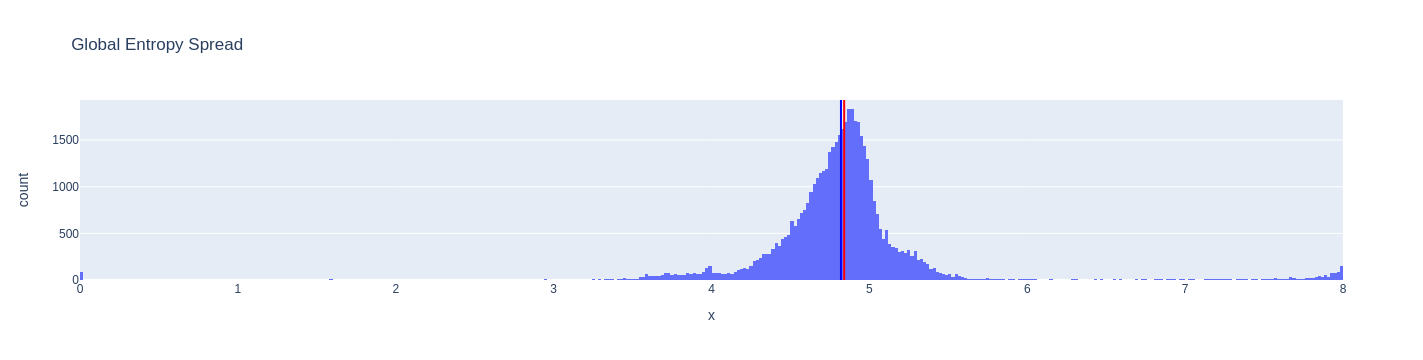

In [37]:
# Full Dataset entropy
fig = px.histogram(x=df.entropy, title="Global Entropy Spread")
# Add mean/median lines
fig.add_vline(x=df.entropy.mean(), line_color="red")
fig.add_vline(x=df.entropy.median(), line_color="blue")

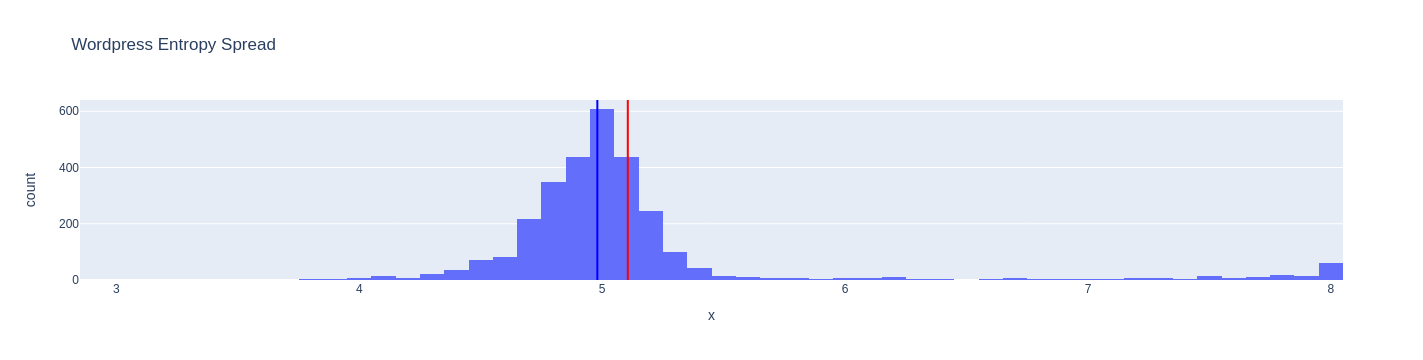

In [38]:
fig = px.histogram(x=df[df.cms == "wordpress"].entropy, title="Wordpress Entropy Spread")
# Add mean/median lines
fig.add_vline(x=df[df.cms == "wordpress"].entropy.mean(), line_color="red")
fig.add_vline(x=df[df.cms == "wordpress"].entropy.median(), line_color="blue")

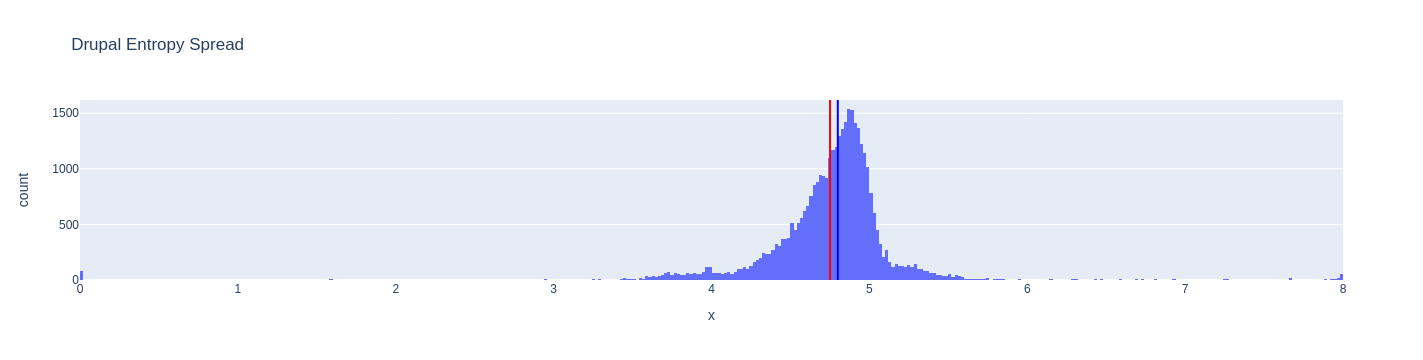

In [39]:
fig = px.histogram(x=df[df.cms == "drupal"].entropy, title="Drupal Entropy Spread")
# Add mean/median lines
fig.add_vline(x=df[df.cms == "drupal"].entropy.mean(), line_color="red")
fig.add_vline(x=df[df.cms == "drupal"].entropy.median(), line_color="blue")

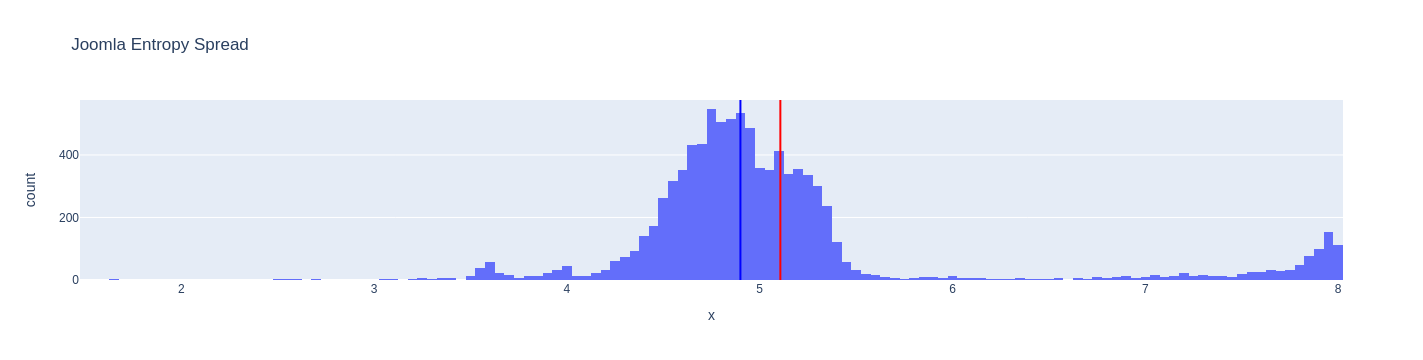

In [40]:
fig = px.histogram(x=df[df.cms == "joomla"].entropy, title="Joomla Entropy Spread")
# Add mean/median lines
fig.add_vline(x=df[df.cms == "joomla"].entropy.mean(), line_color="red")
fig.add_vline(x=df[df.cms == "joomla"].entropy.median(), line_color="blue")

### Conclusions: Entropy Distribution/Central Tendency

With means and medians for all 3 CMSes hovering aroung 5.0, there is plenty of space for obfuscated webshells to potentially exceed this norm. Let's also recall that we are currently analyzing _all_ files in the directories, not just the filetypes that could be web shells (`.php`, in these cases).

But we plainly do have outliers which may impact any utility of entropy-based detection. Let's examine these.

## Outlier Analysis

We want to examine the outliers in our dataset, but first, what constitutes an outlier? We have some tools in Pandas to calculate this. so we'll slice our dataframe into CMS-specific slices for easier analysis. Remember that we care about 1.5x above or below the interquartile range (IQR) for determining...outlierness.

`>= || <= 1.5 * (IQR)`

In [42]:
# Create slices
drupal = df[df.cms=="drupal"]
wordpress = df[df.cms=="wordpress"]
joomla = df[df.cms=="joomla"]

In [45]:
# Calculate the Q1/Q3
q1 = df.entropy.quantile(0.25)
q3 = df.entropy.quantile(0.75)

wordpress_q1 = wordpress.entropy.quantile(0.25)
wordpress_q3 = wordpress.entropy.quantile(0.75)

drupal_q1 = drupal.entropy.quantile(0.25)
drupal_q3 = drupal.entropy.quantile(0.75)

joomla_q1 = joomla.entropy.quantile(0.25)
joomla_q3 = joomla.entropy.quantile(0.75)

In [46]:
# Calculate IQR
iqr = round(stats.iqr(df.entropy), 3)
drupal_iqr = round(stats.iqr(drupal.entropy), 3)
wordpress_iqr = round(stats.iqr(wordpress.entropy), 3)
joomla_iqr = round(stats.iqr(joomla.entropy), 3)

In [47]:
print(f"Global IQR: {iqr} | Global Q1: {q1} | Global Q3: {q3}")
print(f"Drupal IQR: {drupal_iqr} | Drupal Q1: {drupal_q1} | Drupal Q3: {drupal_q3}")
print(f"Wordpress IQR: {wordpress_iqr} | Wordpress Q1: {wordpress_q1} | Wordpress Q3: {wordpress_q3}")
print(f"Joomla IQR: {joomla_iqr} | Joomla Q1: {joomla_q1} | Drupal Q3: {joomla_q3}")

Global IQR: 0.33 | Global Q1: 4.64 | Global Q3: 4.97
Drupal IQR: 0.32 | Drupal Q1: 4.61 | Drupal Q3: 4.93
Wordpress IQR: 0.29 | Wordpress Q1: 4.83 | Wordpress Q3: 5.12
Joomla IQR: 0.52 | Joomla Q1: 4.67 | Drupal Q3: 5.19


In [48]:
# Calculate outliers
outliers_high = df[df.entropy > (q3 + 1.5 * iqr)]
outliers_low = df[df.entropy < (q1 - 1.5 * iqr)]
drupal_outliers_high = drupal[drupal.entropy > (drupal_q3 + 1.5 * drupal_iqr)]
drupal_outliers_low = drupal[drupal.entropy < (drupal_q1 - 1.5 * drupal_iqr)]
wordpress_outliers_high = wordpress[wordpress.entropy > (wordpress_q3 + 1.5 * wordpress_iqr)]
wordpress_outliers_low = wordpress[wordpress.entropy < (wordpress_q1 - 1.5 * wordpress_iqr)]
joomla_outliers_high = joomla[joomla.entropy > (joomla_q3 + 1.5 * joomla_iqr)]
joomla_outliers_low = joomla[joomla.entropy < (joomla_q1 - 1.5 * joomla_iqr)]

For the purposes of our work, we only care about _high_ outliers, given the reasonable assumption that obfuscated web shells will be _more_ entropic than our mean/median.

### File Extensions

What kinds of files _are_ outliers, anyway?

#### Global Outlier Extensions

In [55]:
# Global 
outliers_high.groupby("extension").count().sort_values(by="filename", ascending=False)[["index"]]

,index
extension,
.gz,765
.js,396
.png,283
.gif,150
.jpg,89
.woff2,77
.woff,31
.css,26
.ini,24


#### WordPress Outlier Extensions

In [57]:
# Wordpress 
wordpress_outliers_high.groupby("extension").count().sort_values(by="filename", ascending=False)[["index"]]

,index
extension,
.png,109
.gif,44
.woff2,29
.jpg,19
.ttf,8
.css,4
.eot,3
.woff,3
.crt,1


#### Drupal Outlier Extensions

In [58]:
# Drupal
drupal_outliers_high.groupby("extension").count().sort_values(by="filename", ascending=False)[["index"]]

,index
extension,
.js,460
.png,156
.jpg,50
.woff2,22
.gif,18
.gz,14
.php,14
.css,12
.jpeg,4


#### Joomla Outlier Extensions

In [59]:
# Joomla
joomla_outliers_high.groupby("extension").count().sort_values(by="filename", ascending=False)[["index"]]

,index
extension,
.gz,748
.gif,43
.woff2,26
.woff,26
.jpg,20
.png,16
.swf,5
.eot,4
.html,4


Okay, so we have _some_ PHP files in here, but the vast majority of outliers are other kinds of files.

These are mostly expected, as compressed files, fonts, and images are naturally entropic.

CSS files are a bit of a surprise, but this may result from the base64-encoded images often included in them.

But now it's time to focus down on PHP files, to see how entropic they are specifically.

## PHP Analysis

In [62]:
# Getting php files
php = df[df.extension == ".php"]

In [63]:
php.shape

(27486, 6)

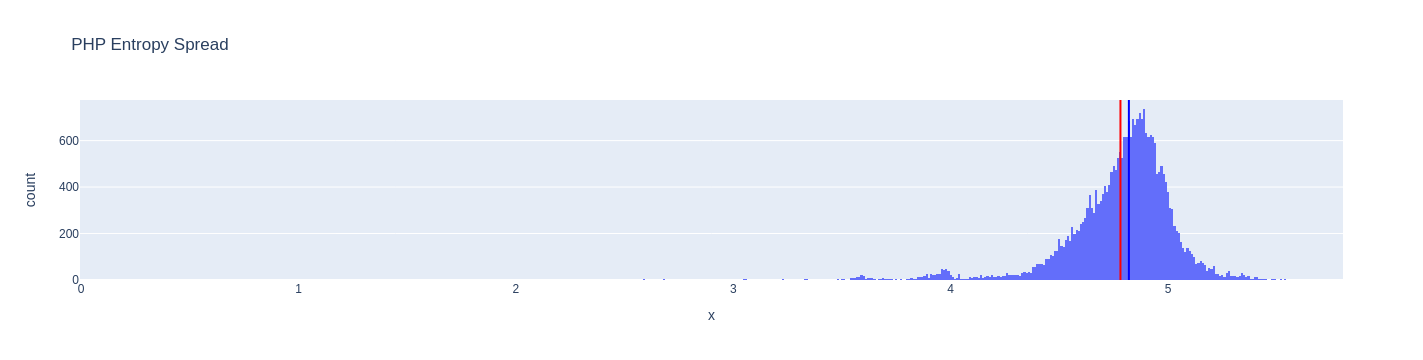

In [64]:
# PHP Calculation
fig = px.histogram(x=php.entropy, title="PHP Entropy Spread")
# Add mean/median lines
fig.add_vline(x=php.entropy.mean(), line_color="red")
fig.add_vline(x=php.entropy.median(), line_color="blue")

In [ ]:
print(f"Mean PHP Entropy: {php.entropy.mean()}")
print(f"Median PHP Entropy: {php.entropy.median()}")

Mean PHP Entropy: 4.7812482718474865
Median PHP Entropy: 4.82


As a reminder, what's the global outlier threshold?

In [66]:
# Magic Global Entropy Number 
round((q3 + 1.5 * iqr), 2)

5.46

Now what about PHP files?

In [67]:
# PHP Outliers
php_q1 = php.entropy.quantile(0.25)
php_q3 = df.entropy.quantile(0.75)
php_iqr = round(stats.iqr(php.entropy), 3)
php_outliers_high = php[php.entropy > (php_q3 + 1.5 * php_iqr)]
php_outliers_low = php[php.entropy < (php_q1 - 1.5 * php_iqr)]

In [68]:
# Max/Min outliers
print(f"Min PHP Outlier: {php_outliers_high.entropy.min()}")
print(f"Max PHP Outlier: {php_outliers_high.entropy.max()}")

Min PHP Outlier: 5.35
Max PHP Outlier: 5.8


In [69]:
# Magic PHP Global Entropy Number 
round((php_q3 + 1.5 * php_iqr), 2)

5.34

### PHP Conclusions

So we know that the PHP outlier threshold is lower than the global threshold. That could be problematic, or it could mean that we have even more space for detection, depending on what the malware looks like.

We'll continue to investigate the malicious obfuscated webshells in [Webshell-EDA.ipynb](Webshell-EDA.ipynb)